<a href="https://colab.research.google.com/github/DrYGuo/Defect-detection-in-atomic-resolution-image-via-unsupervised-learning-with-translational-invariance/blob/main/STEM_of_ZrO2_NP_(Scheme_2_demonstratioin).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Read tif and display the image

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path='/content/drive/Shareddrives/TMD_NIST/Monoclinic structure for defect detection/ZrO2_monoclinic.tif'

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import scipy


In [4]:
plt.set_cmap('gray')

<Figure size 432x288 with 0 Axes>

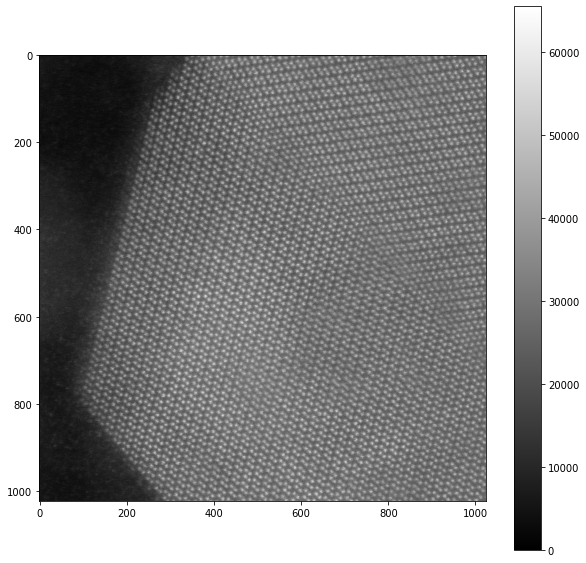

In [5]:
image = Image.open(path)
ZrO2=np.array(image)
plt.figure(figsize=(10,10))
plt.imshow(ZrO2,cmap='gray')
plt.colorbar()

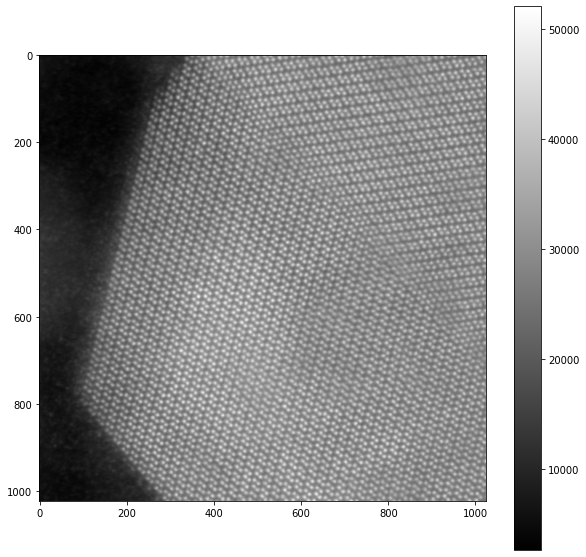

In [6]:
import scipy.ndimage
ZrO2_smoothed=scipy.ndimage.gaussian_filter(ZrO2,sigma=1.5)
plt.figure(figsize=(10,10))
plt.imshow(ZrO2_smoothed)
plt.colorbar()

Find all the atom positions

(4664, 2)

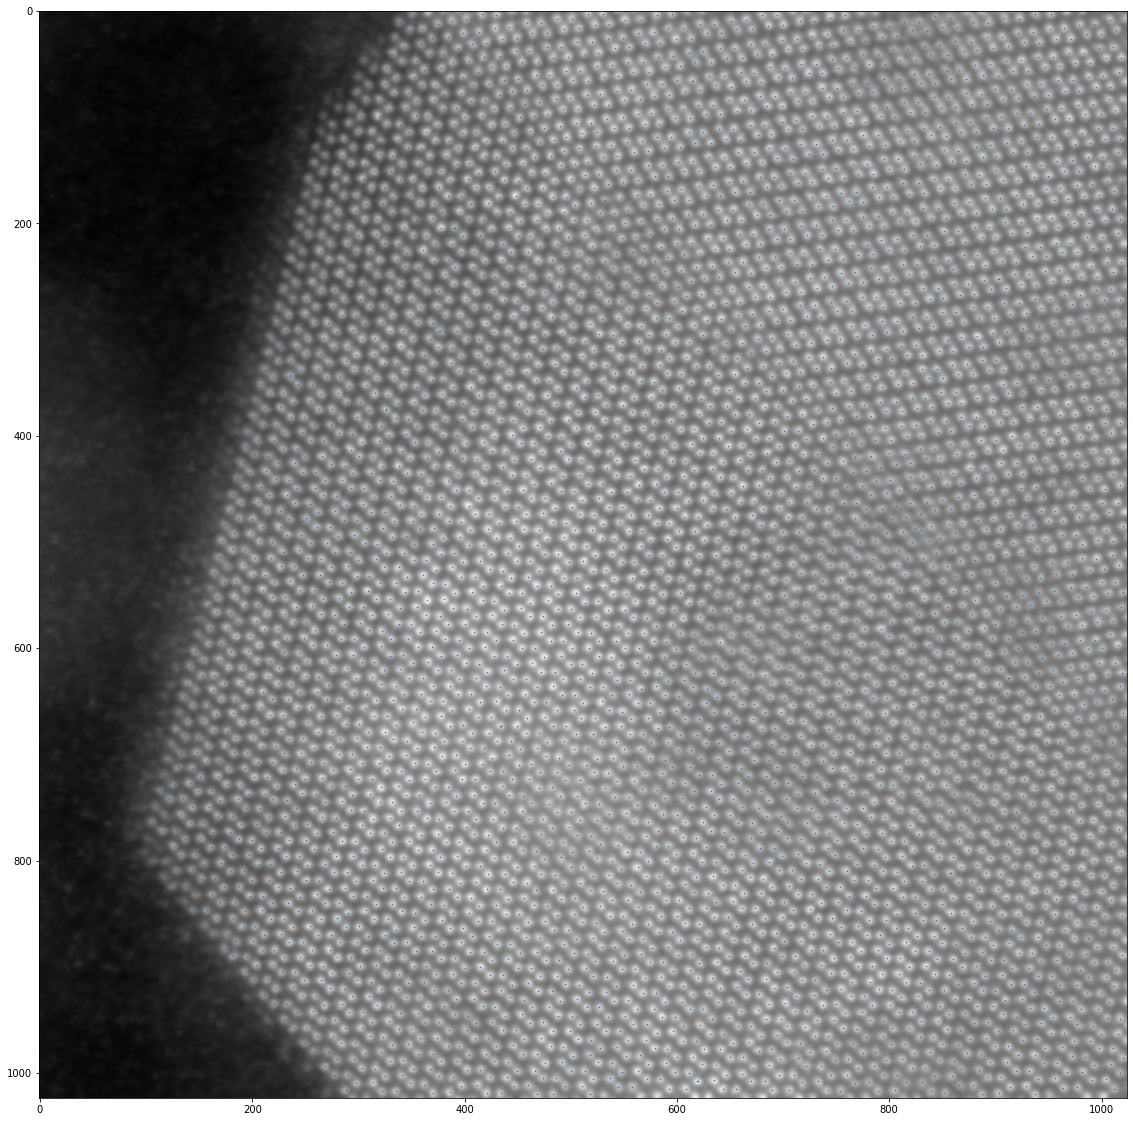

In [7]:
from skimage.feature import peak_local_max
atomXY_temp=peak_local_max(ZrO2_smoothed, min_distance=3,threshold_abs=2e4)
plt.figure(figsize=(20,20))
plt.imshow(ZrO2_smoothed)
plt.scatter(atomXY_temp[:,1],atomXY_temp[:,0],s=0.5)
atomXY_temp.shape

In [8]:
atomXY_temp.shape

(4664, 2)

2. Create a semantic image

2D Gaussian-like array:
(16, 16)


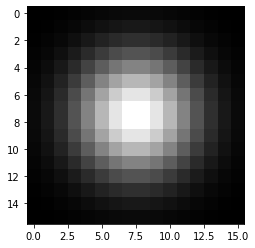

In [9]:
# create a 2d Gaussian distribution
atom_size=16
r_atom=int(atom_size/2)
x, y = np.meshgrid(np.linspace(-1,1,atom_size), np.linspace(-1,1,atom_size))
d = np.sqrt(x*x+y*y)
sigma, mu = 0.4, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
print("2D Gaussian-like array:")
print(g.shape)
plt.imshow(g)

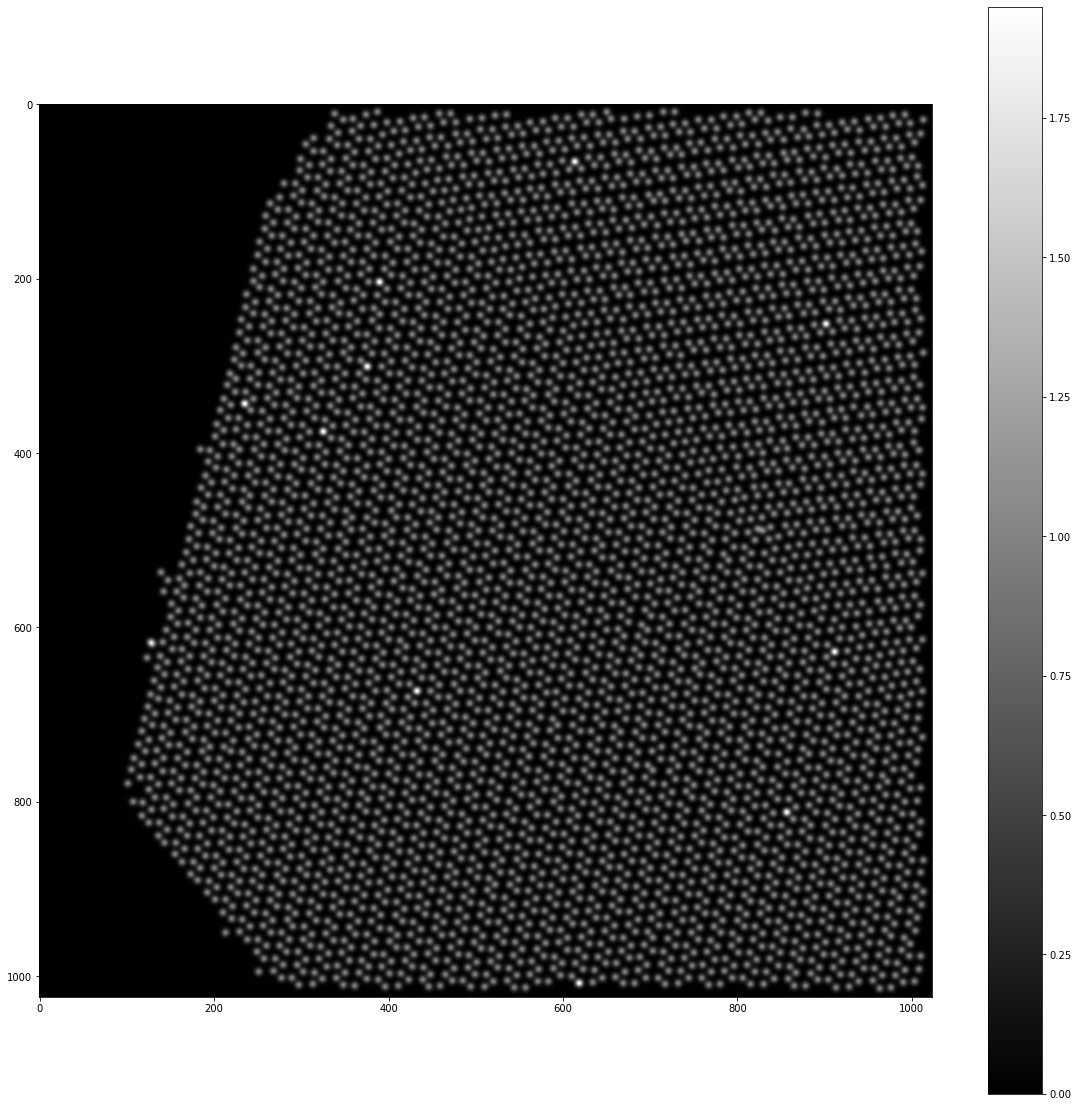

In [10]:
semantic_image=np.zeros((ZrO2.shape[0],ZrO2.shape[1]))
for j, x_y in enumerate(atomXY_temp):
   x=x_y[0]
   y=x_y[1]
   if x-r_atom>0 and x+r_atom+1<=semantic_image.shape[0]-1 and y-r_atom>0 and y+r_atom+1<=semantic_image.shape[1]-1:
         semantic_image[x-r_atom:x+r_atom,y-r_atom:y+r_atom]=g+semantic_image[x-r_atom:x+r_atom,y-r_atom:y+r_atom]

plt.figure(figsize=(20,20))
plt.imshow(semantic_image)
plt.colorbar()

In [11]:
atomXY_temp[4661:,:]

array([[  3, 516],
       [  3, 416],
       [  3, 351]])

In [12]:
semantic_image2=semantic_image.copy()

In [13]:
atomXY_temp2=atomXY_temp.copy()
for i, (x,y) in enumerate(atomXY_temp):
  for (x1,y1) in atomXY_temp[i+1:,:]:
    if (x-x1)**2+(y-y1)**2<=2:
      print('identical pair')
      print(x,y)
      atomXY_temp2=np.delete(atomXY_temp2,i,0)
      semantic_image2[x-r_atom:x+r_atom,y-r_atom:y+r_atom]=semantic_image[x-r_atom:x+r_atom,y-r_atom:y+r_atom]-g

identical pair
1008 620
identical pair
812 858
identical pair
673 434
identical pair
628 913
identical pair
376 326
identical pair
344 236
identical pair
301 377
identical pair
252 903
identical pair
204 391
identical pair
66 615


In [ ]:
atomXY_temp2.shape

(4654, 2)

The Polished semantic_image2

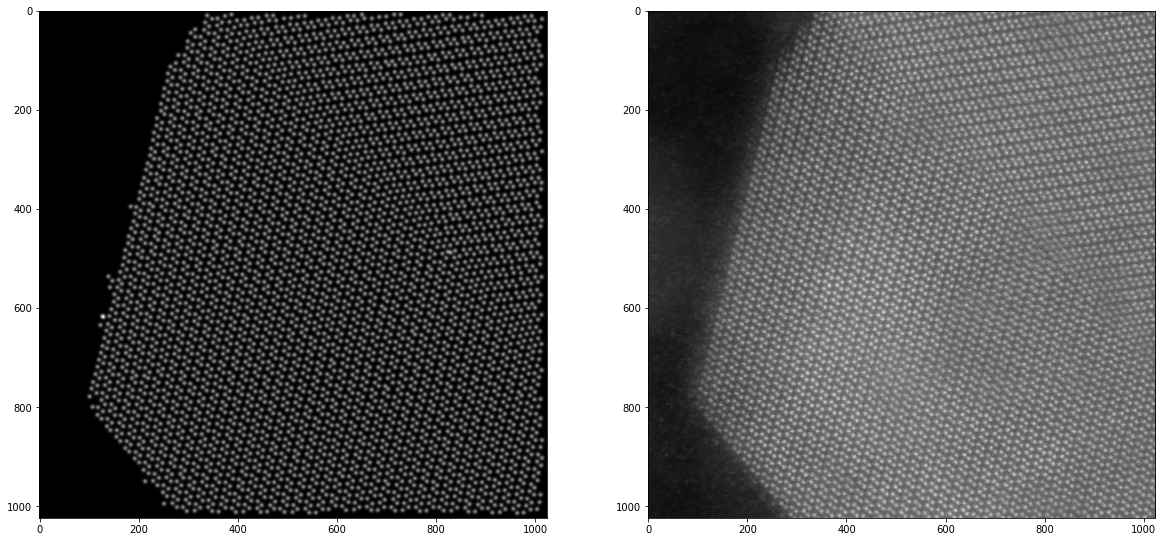

In [14]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(semantic_image2)
plt.subplot(122)
plt.imshow(ZrO2)

# 3. FFT and IFFT

(-0.5, 1023.5, 1023.5, -0.5)

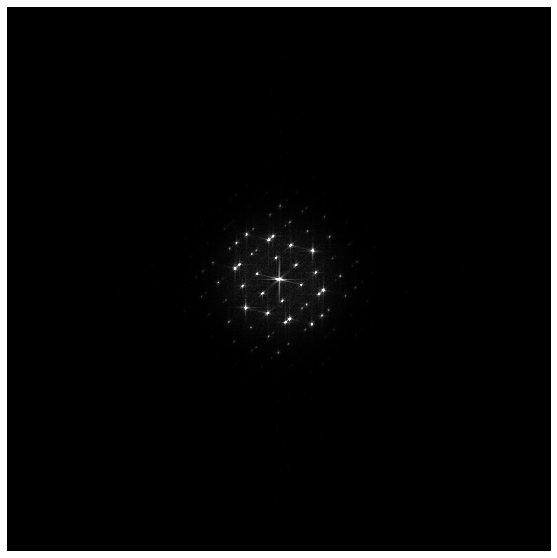

In [15]:
FFT=scipy.fft.fft2(semantic_image2)
FFT_shift=scipy.fft.fftshift(FFT)
plt.figure(figsize=(10,10))
plt.imshow(abs(FFT_shift),vmax=5e3)
# plt.colorbar()
plt.axis('off')

(35, 2)


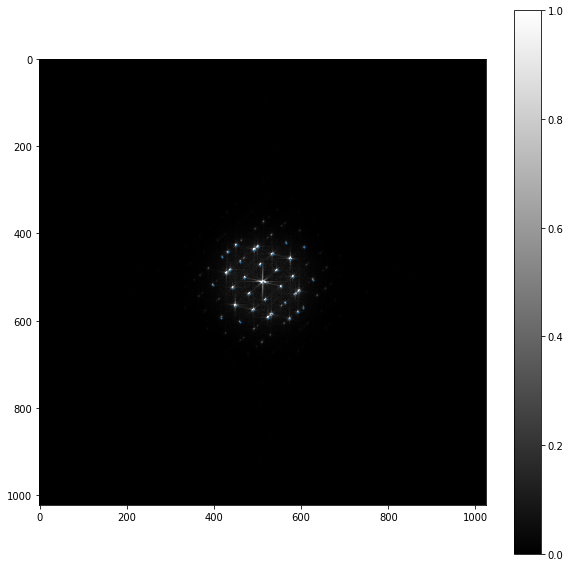

In [16]:
from skimage.feature import peak_local_max
FFT_peaks= peak_local_max(abs(FFT_shift), min_distance=5,threshold_abs=4.5e3)
plt.figure(figsize=(10,10))
plt.imshow(abs(FFT_shift),vmax=5e3)
plt.scatter(FFT_peaks[:,1],FFT_peaks[:,0],s=1)
plt.colorbar()
print(FFT_peaks.shape)

In [17]:
import math
k_distance=np.zeros((FFT_peaks.shape[0]))
k_peaks=np.zeros((FFT_peaks.shape[0],3))
FFT_X=FFT.shape[0]
FFT_Y=FFT.shape[1]
print(k_peaks.shape)
for i, (x,y) in enumerate(FFT_peaks):
  k_distance[i]=math.sqrt((x-FFT_X/2)**2+(y-FFT_Y/2)**2)
  k_peaks[i,:]=(x,y,k_distance[i])
  # print(x,y,k_distance[i])
# print(k_distance)
print(k_peaks)
print('sorted')
sorted_k_peaks=k_peaks[k_peaks[:,2].argsort()] # sort k_peaks by the second column, k_distance
print(sorted_k_peaks)
print('k_peaks: row, col,length')
print(k_peaks)

(35, 3)
[[603.         459.         105.30906894]
 [597.         573.         104.6231332 ]
 [593.         524.          81.88406438]
 [593.         417.         124.84390253]
 [586.         532.          76.65507159]
 [581.         592.         105.64563408]
 [576.         490.          67.67569726]
 [570.         605.         109.60383205]
 [566.         449.          82.97590012]
 [559.         564.          70.09279564]
 [552.         518.          40.44749683]
 [540.         587.          80.05623024]
 [539.         480.          41.86884283]
 [533.         595.          85.61541917]
 [525.         443.          70.21395873]
 [522.         554.          43.17406629]
 [518.         397.         115.15641537]
 [512.         512.           0.        ]
 [506.         627.         115.15641537]
 [502.         470.          43.17406629]
 [499.         581.          70.21395873]
 [491.         429.          85.61541917]
 [485.         544.          41.86884283]
 [484.         437.       

In [18]:
k_vectors=np.zeros((6,2))

for i in range(6):
   k_vectors[i,0]=sorted_k_peaks[i+1,0]-FFT_X/2
   k_vectors[i,1]=sorted_k_peaks[i+1,1]-FFT_Y/2

print(k_vectors)

[[ 40.   6.]
 [-40.  -6.]
 [ 27. -32.]
 [-27.  32.]
 [-10. -42.]
 [ 10.  42.]]


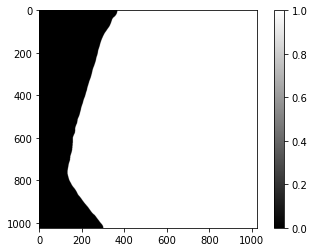

In [19]:
margin_size=20
particle_mask_new=np.zeros((1024,1024))
particle_mask_heavily_smoothed=scipy.ndimage.gaussian_filter(ZrO2,sigma=10)


for i in range(1024):
  for j in range(int(1024-2*margin_size)):
     if particle_mask_heavily_smoothed[i,j]>1.5e4:
        particle_mask_new[i,int(j+2*margin_size)]=1

plt.imshow(particle_mask_new)
plt.colorbar()

(4107, 2)


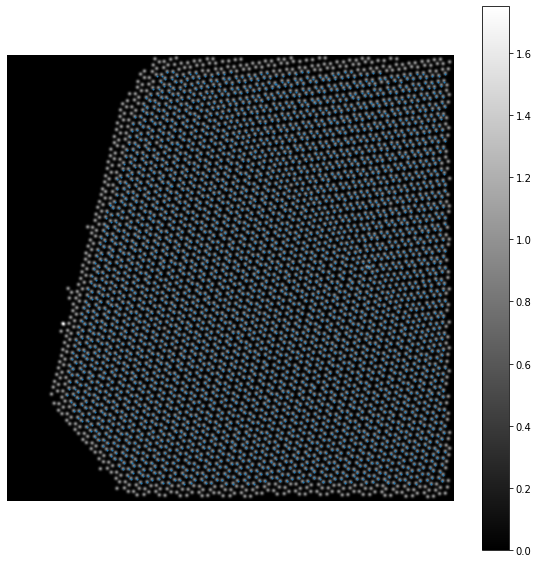

In [20]:
atomXY=np.zeros((1,2))

for i, (x,y) in enumerate(atomXY_temp2):
   if x>=margin_size*2 and x<=1024-margin_size*2 and y>=margin_size and y<=1024-margin_size and particle_mask_new[x,y]>0:
      atomXY=np.vstack([atomXY,[x,y]])   
atomXY=np.delete(atomXY,0,axis=0)

print(atomXY.shape)
plt.figure(figsize=(10,10))
plt.scatter(atomXY[:,1],atomXY[:,0],s=1)
plt.imshow(semantic_image2)
plt.axis('off') 
plt.colorbar()

Now, I come up with the following idea:

Multi-channel IFFT

Identify all the atom positions
Find the shortest k_vectors from the FFT, say 3 basis k_vectors, k1, k2, k3 Thus, we also know the corresponding spacings in real space d1, d2, d3
Take the IFFT for each k_vector
At each atom position, crop the IFFT images IFFT1, IFFT2 and IFFT3 with three squared boxes with d1, d2, and d3
Take the Patterson function of each cropped image and form P1, P2 and P3
Then, we have a 3-channel tensor for each atom, since each channel has a different dimension we fill the empty elements with zeros.
Then, we are ready to do classfications. We may expect that this classfication could give different domains with different unit cells and twin boundaries. Thus, we can classify different phases. Each phase correspond to 2 of the 3 channels. And we can also detect defects within each phase.

Getting the cos and sin for each k_vector

In [21]:
window=np.zeros((55,55))
shift_center=math.floor(window.shape[0]/2)
cos_alpha_list=np.zeros((k_vectors.shape[0]))
sin_alpha_list=np.zeros((k_vectors.shape[0]))

for i in range(k_vectors.shape[0]):
  cos_alpha_list[i]=k_vectors[i,0]/math.sqrt(k_vectors[i,0]**2+k_vectors[i,1]**2)
  sin_alpha_list[i]=k_vectors[i,1]/math.sqrt(k_vectors[i,0]**2+k_vectors[i,1]**2)
print(cos_alpha_list)

[ 0.98893635 -0.98893635  0.64487094 -0.64487094 -0.23162053  0.23162053]


FFT_mask

In [22]:
def FFT_mask(k_vector_i,r_mask):
   k_x=k_vector_i[0]
   k_y=k_vector_i[1]
   FFT_mask=np.zeros((FFT.shape[0],FFT.shape[1]))
   for i in range(-r_mask,r_mask):
     for j in range(-r_mask,r_mask):
        if i**2+j**2<=r_mask**2:
          #  print(k_x,k_y)
           FFT_mask[int(FFT.shape[0]/2+k_x+i),int(FFT.shape[1]/2+k_y+j)]=1
           FFT_mask[int(FFT.shape[0]/2-k_x+i),int(FFT.shape[1]/2-k_y+j)]=1
   
   return FFT_mask

[40.  6.]


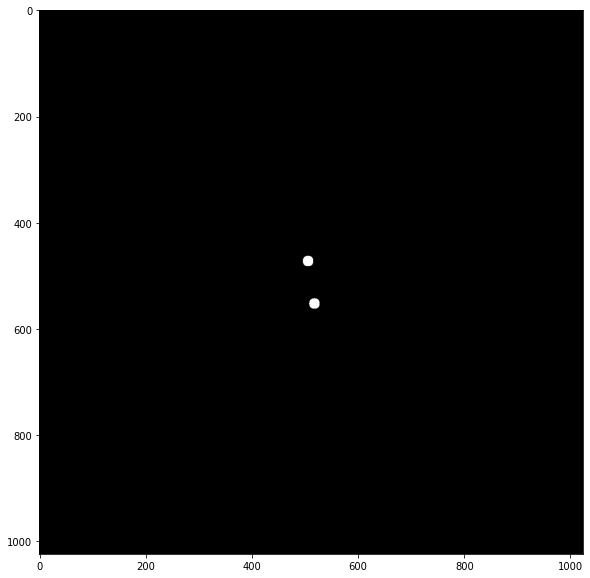

In [23]:
r_mask=20
k_vector_i=k_vectors[0,:]
print(k_vector_i)
plt.figure(figsize=(10,10))
plt.imshow(FFT_mask(k_vectors[0,:],r_mask=10))

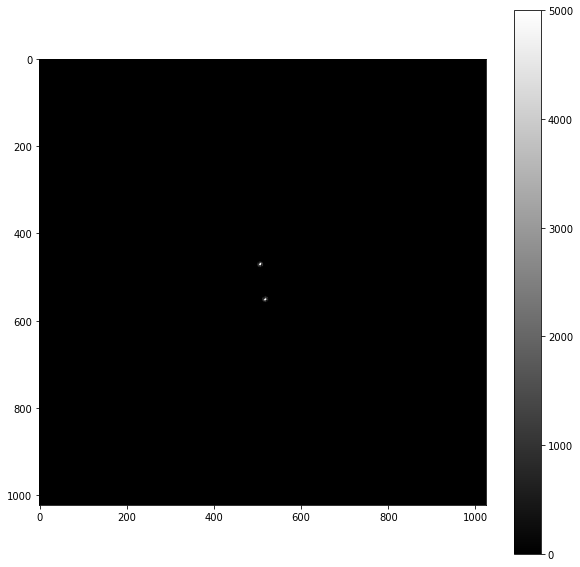

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(abs(FFT_shift*FFT_mask(k_vectors[0,:],r_mask=7)),vmax=5e3)
plt.colorbar()

(-0.5, 1023.5, 1023.5, -0.5)

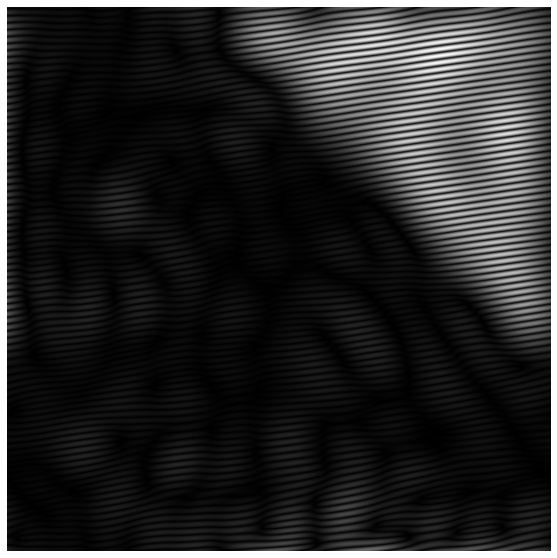

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(abs(scipy.fft.ifft2(FFT_shift*FFT_mask(k_vectors[0,:],r_mask=7))))
# plt.colorbar()
plt.axis('off')

In [26]:
IFFT_1=abs(scipy.fft.ifft2(FFT_shift*FFT_mask(k_vectors[0,:],r_mask=5)))
IFFT_2=abs(scipy.fft.ifft2(FFT_shift*FFT_mask(k_vectors[2,:],r_mask=5)))
IFFT_3=abs(scipy.fft.ifft2(FFT_shift*FFT_mask(k_vectors[4,:],r_mask=5)))

(-0.5, 1023.5, 1023.5, -0.5)

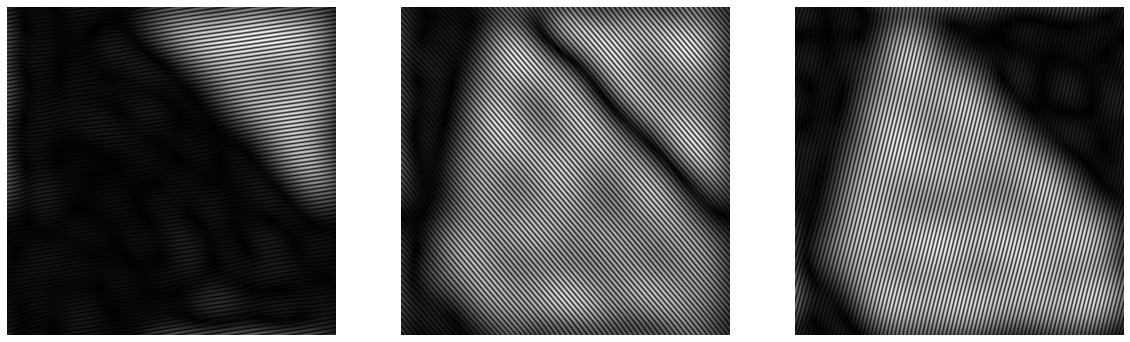

In [27]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(20,20))
# fig.suptitle('Inverse FFT of three k_vectors')
ax1.imshow(IFFT_1)
ax1.axis('off')
ax2.imshow(IFFT_2)
ax2.axis('off')
ax3.imshow(IFFT_3)
ax3.axis('off')

Rotate the three IFFT images by the angles between the k_vector and the horizontal direction. In the meantime, rotate the atomXY and get the corresponding coordinates in the new images.

These alpha are the angle between the normal vectors to the planes and the vertical direction

In [28]:
cos_alpha_list=np.zeros((k_vectors.shape[0]))
sin_alpha_list=np.zeros((k_vectors.shape[0]))

for i in range(k_vectors.shape[0]):
  cos_alpha_list[i]=k_vectors[i,0]/math.sqrt(k_vectors[i,0]**2+k_vectors[i,1]**2)
  sin_alpha_list[i]=k_vectors[i,1]/math.sqrt(k_vectors[i,0]**2+k_vectors[i,1]**2)
print(cos_alpha_list)
print(sin_alpha_list)

[ 0.98893635 -0.98893635  0.64487094 -0.64487094 -0.23162053  0.23162053]
[ 0.14834045 -0.14834045 -0.76429148  0.76429148 -0.97280621  0.97280621]


In [29]:
alpha_list=np.zeros((3))
for i in range(3):
  alpha_list[i]=math.atan(sin_alpha_list[2*i]/cos_alpha_list[2*i])*180/math.pi
print(alpha_list)

[  8.53076561 -49.84400038  76.60750225]


In [30]:
rot_angles=-alpha_list
print(rot_angles)

[ -8.53076561  49.84400038 -76.60750225]


In [31]:
from scipy.ndimage import rotate

def rot(image, xy, angle):
    im_rot = rotate(image,angle)
    xy_new=xy.copy()
    org_center = (np.array(image.shape[:2][::-1]))/2
    rot_center = (np.array(im_rot.shape[:2][::-1]))/2
    for i,x_y in enumerate(xy):
      org=x_y-org_center
      a = -np.deg2rad(angle) # a minus sign works because the "row=x, col=y" convention is adopted here
      new = np.array([org[0]*np.cos(a) + org[1]*np.sin(a),
            -org[0]*np.sin(a) + org[1]*np.cos(a)])
      xy_new[i,:]=new+rot_center
    
    return im_rot, xy_new



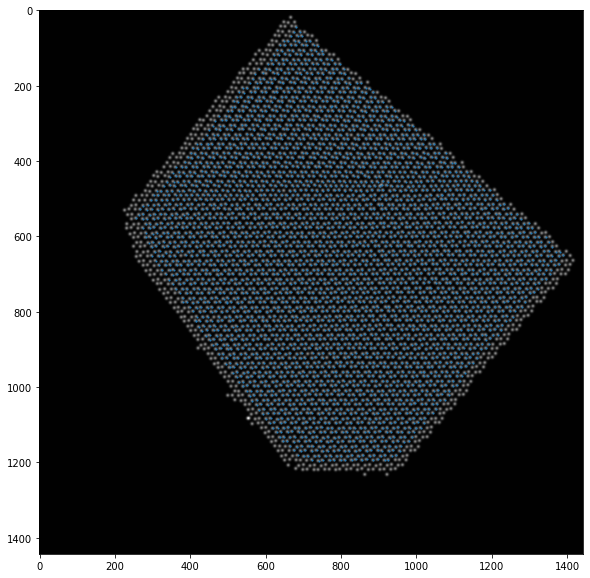

In [32]:
data_rot, xy_new= rot(semantic_image2, atomXY, rot_angles[1])
plt.figure(figsize=(10,10))
plt.imshow(data_rot)
plt.scatter(xy_new[:,1],xy_new[:,0],s=1)

In [33]:
IFFT1_rot, atomXY_rot1= rot(IFFT_1, atomXY, rot_angles[0])
IFFT2_rot, atomXY_rot2= rot(IFFT_2, atomXY, rot_angles[1])
IFFT3_rot, atomXY_rot3= rot(IFFT_3, atomXY, rot_angles[2])
print(IFFT1_rot.shape,IFFT2_rot.shape,IFFT3_rot.shape)
print(atomXY_rot1.shape,atomXY_rot2.shape,atomXY_rot3.shape)

(1165, 1165) (1443, 1443) (1233, 1233)
(4107, 2) (4107, 2) (4107, 2)


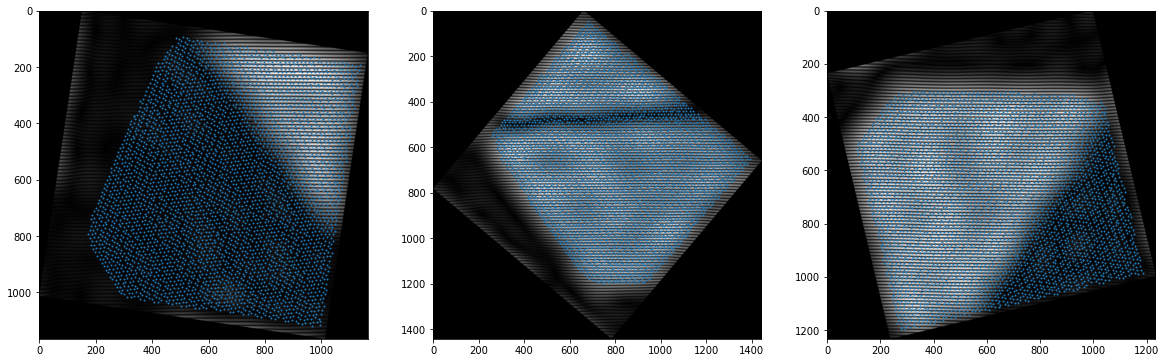

In [34]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(20,20))
# fig.suptitle('Inverse FFT of three k_vectors')
ax1.imshow(IFFT1_rot)
ax1.scatter(atomXY_rot1[:,1],atomXY_rot1[:,0],s=1)
ax2.imshow(IFFT2_rot)
ax2.scatter(atomXY_rot2[:,1],atomXY_rot2[:,0],s=1)
ax3.imshow(IFFT3_rot)
ax3.scatter(atomXY_rot3[:,1],atomXY_rot3[:,0],s=1)

determine the length of the subimages

In [46]:
d_spacings=np.zeros((3))
for i in range(3):
  d_spacings[i]=round(ZrO2.shape[0]/math.sqrt(k_vectors[2*i,0]**2+k_vectors[2*i,1]**2))
print(d_spacings)

[25. 24. 24.]


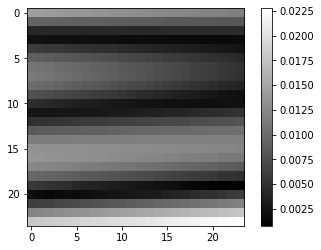

In [47]:
plt.imshow(IFFT2_rot[460:int(460+d_spacings[1]),800:int(800+d_spacings[1])])
plt.colorbar()

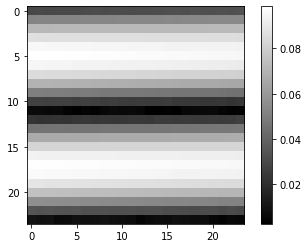

In [48]:
plt.imshow(IFFT2_rot[800:int(800+d_spacings[1]),800:int(800+d_spacings[1])])
plt.colorbar()

## 4. At each atom position, crop the IFFT images IFFT1, IFFT2 and IFFT3 with three squared boxes with d1, d2, and d3
## 5. Take the Patterson function of each cropped image and form P1, P2 and P3

In [49]:
IFFT2_rot.shape

(1443, 1443)

In [50]:
def Patterson(im):
   FFT=scipy.fft.fft2(im)
   patterson=scipy.fft.ifft2(abs(FFT)**2)
   patt=scipy.fft.ifftshift(patterson)
   return abs(patt)

In [51]:
def prep_stack(atomXY_rot1,IFFT1_rot,d_spacing):
   d_spacing=round(d_spacing)
   im_stack_IFFT1=np.zeros((int(atomXY_rot1.shape[0]),int(d_spacing),int(d_spacing)))
   for i, (x,y) in enumerate(atomXY_rot1):
     d_half=d_spacing/2
     im_temp=IFFT1_rot[int(x-d_half):int(x+d_half),int(y-d_half):int(y+d_half)]
     im_stack_IFFT1[i,:,:]=Patterson(im_temp) 
   return im_stack_IFFT1

In [52]:
def Batch_normalization(img_stack):
   z=img_stack.shape[0]
   x=img_stack.shape[1]
   y=img_stack.shape[2]
   im_stack_IFFT=(img_stack-np.mean(img_stack))/math.sqrt(np.var(img_stack))
   return im_stack_IFFT

Bartche_normalized IFFT stacks

In [53]:
im_stack_IFFT1=Batch_normalization(prep_stack(atomXY_rot1,IFFT1_rot,d_spacings[0]))
im_stack_IFFT2=Batch_normalization(prep_stack(atomXY_rot2,IFFT2_rot,d_spacings[1]))
im_stack_IFFT3=Batch_normalization(prep_stack(atomXY_rot3,IFFT3_rot,d_spacings[2]))

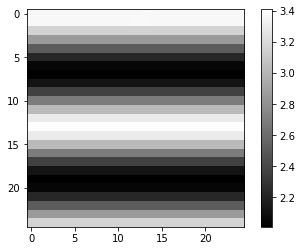

In [54]:
plt.imshow(im_stack_IFFT1[4001,:,:])
plt.colorbar()

In [55]:
def prep_stack_flat(im_stack_IFFT1):

  img_stack=im_stack_IFFT1
  img_stack_flat=img_stack.reshape(img_stack.shape[0],img_stack.shape[1]*img_stack.shape[2])
  print(img_stack_flat.shape)
  return img_stack_flat

In [56]:
img_stack_flat_1=prep_stack_flat(im_stack_IFFT1)
img_stack_flat_2=prep_stack_flat(im_stack_IFFT2)
img_stack_flat_3=prep_stack_flat(im_stack_IFFT3)

(4107, 625)
(4107, 576)
(4107, 576)


# 6. Do the classification using SVM

Reduce the dimension by PCA

In [57]:
def PCA_reduction(img_stack_flat):

   from sklearn.decomposition import PCA
   pca=PCA()
   pca.fit(img_stack_flat[:,:])              
# pca.fit(img_stack_init_flat[:,:])
   explained_var = pca.explained_variance_ratio_
   sum=0
   nc=0
   i=0
   while sum<0.9999:
       print(str(i+1)+'th component accounts for:'+str(explained_var[i]))
       sum=sum+explained_var[i]
       nc=nc+1
       i=i+1
   print(str(nc)+'components can explain'+str(sum)+'of the behavior')

   NC=3
   pca = PCA(n_components=NC)
   X_vec_t = pca.fit_transform(img_stack_flat[:,:])
   components = pca.components_

   print('shape of the components is')
   print(components.shape)
   print(X_vec_t.shape)
   return X_vec_t

In [58]:
X_vec_t_1=PCA_reduction(img_stack_flat_1)
X_vec_t_2=PCA_reduction(img_stack_flat_2)
X_vec_t_3=PCA_reduction(img_stack_flat_3)

1th component accounts for:0.9999821586697567
1components can explain0.9999821586697567of the behavior
shape of the components is
(3, 625)
(4107, 3)
1th component accounts for:0.9993413773229165
2th component accounts for:0.0006255188435138035
2components can explain0.9999668961664303of the behavior
shape of the components is
(3, 576)
(4107, 3)
1th component accounts for:0.9999667245386047
1components can explain0.9999667245386047of the behavior
shape of the components is
(3, 576)
(4107, 3)


In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 32}

matplotlib.rc('font', **font)

Text(0, 0.5, 'D(v)')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


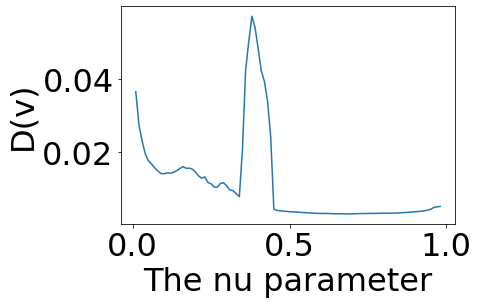

In [ ]:
from sklearn.svm import OneClassSVM

X_vec_t=X_vec_t_1

gamma_ratios=np.arange(0.5,3,0.5)

nu_min=0.01
nu_max=0.99
nu_step=0.01
#the number of nu i the horizontal direction
nu_num=(nu_max-nu_min)/nu_step
nu_num=int(nu_num)
gamma_0=1/(X_vec_t.shape[1]*X_vec_t[:,:].var())

#the number of gamma
gamma_num=len(gamma_ratios)

Dvs=np.zeros((gamma_num,nu_num))

for j,gamma_ratio in enumerate(gamma_ratios):
   for i, nu in enumerate(np.arange(nu_min,nu_max,nu_step)):
      clf=OneClassSVM(gamma=gamma_ratio*gamma_0,nu=nu,max_iter=-1).fit(X_vec_t)
      decision_f=clf.decision_function(X_vec_t)
      P1=np.median(decision_f[np.where(decision_f<=0)])
      P2=np.median(decision_f[np.where(decision_f>0)])
      Dv=(P2-P1)/(decision_f.max()-decision_f.min())
      Dvs[j,i]=Dv
    

plt.plot(np.arange(nu_min,nu_max,nu_step),Dvs[0,:])
plt.xlabel('The nu parameter')
plt.ylabel('D(v)')

1.0


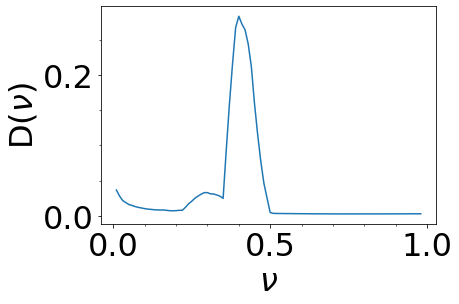

In [ ]:
ratio_rank=1

plt.plot(np.arange(nu_min,nu_max,nu_step),Dvs[ratio_rank,:])
plt.xlabel(r'$\nu$')
plt.ylabel('D('r'$\nu$'')')
# plt.xlim(0.3,0.5)
plt.minorticks_on()
# plt.ylim(0,0.5)
print(gamma_ratios[ratio_rank])

(array([2.000e+00, 7.000e+00, 7.000e+00, 5.000e+00, 3.000e+00, 2.000e+00,
        6.000e+00, 6.000e+00, 6.000e+00, 6.000e+00, 2.000e+00, 4.000e+00,
        6.000e+00, 5.000e+00, 3.000e+00, 2.000e+00, 9.000e+00, 5.000e+00,
        5.000e+00, 9.000e+00, 3.000e+00, 6.000e+00, 6.000e+00, 0.000e+00,
        5.000e+00, 1.000e+01, 1.200e+01, 6.000e+00, 1.100e+01, 7.000e+00,
        1.300e+01, 1.200e+01, 2.000e+01, 1.500e+01, 2.000e+01, 2.000e+01,
        2.100e+01, 2.700e+01, 3.800e+01, 2.150e+02, 1.380e+02, 1.600e+01,
        1.100e+01, 9.000e+00, 9.000e+00, 7.000e+00, 8.000e+00, 9.000e+00,
        1.100e+01, 7.000e+00, 7.000e+00, 4.000e+00, 2.000e+00, 6.000e+00,
        5.000e+00, 5.000e+00, 7.000e+00, 4.000e+00, 4.000e+00, 3.000e+00,
        1.000e+01, 5.000e+00, 4.000e+00, 9.000e+00, 6.000e+00, 4.000e+00,
        4.000e+00, 4.000e+00, 3.000e+00, 5.000e+00, 5.000e+00, 3.000e+00,
        5.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 3.000e+00,
        5.000e+00, 6.000e+00, 2.000e+0

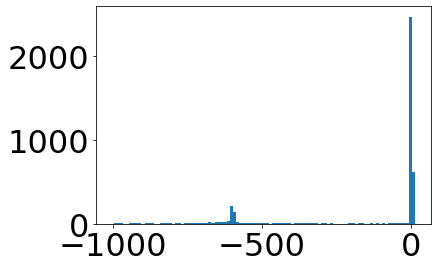

In [ ]:
clf=OneClassSVM(kernel='rbf',gamma=1*gamma_0,nu=0.5,max_iter=-1,).fit(X_vec_t)
decision_f_1=clf.decision_function(X_vec_t)
cate=clf.predict(X_vec_t)
plt.hist(decision_f_1,bins=100)
# plt.xlim(-620,0)
# plt.ylim(0,300)
# plt.hist(cate)

In [ ]:
decision_f=decision_f_1
lower_limit=-100

In [ ]:
color_outlier=np.zeros((img_stack_flat_2.shape[0]))
for i in range(color_outlier.shape[0]):
  if decision_f[i]>lower_limit:
    color_outlier[i]=1
  if decision_f[i]<=lower_limit:
    color_outlier[i]=-1

(-0.5, 1023.5, 1023.5, -0.5)

<Figure size 432x288 with 0 Axes>

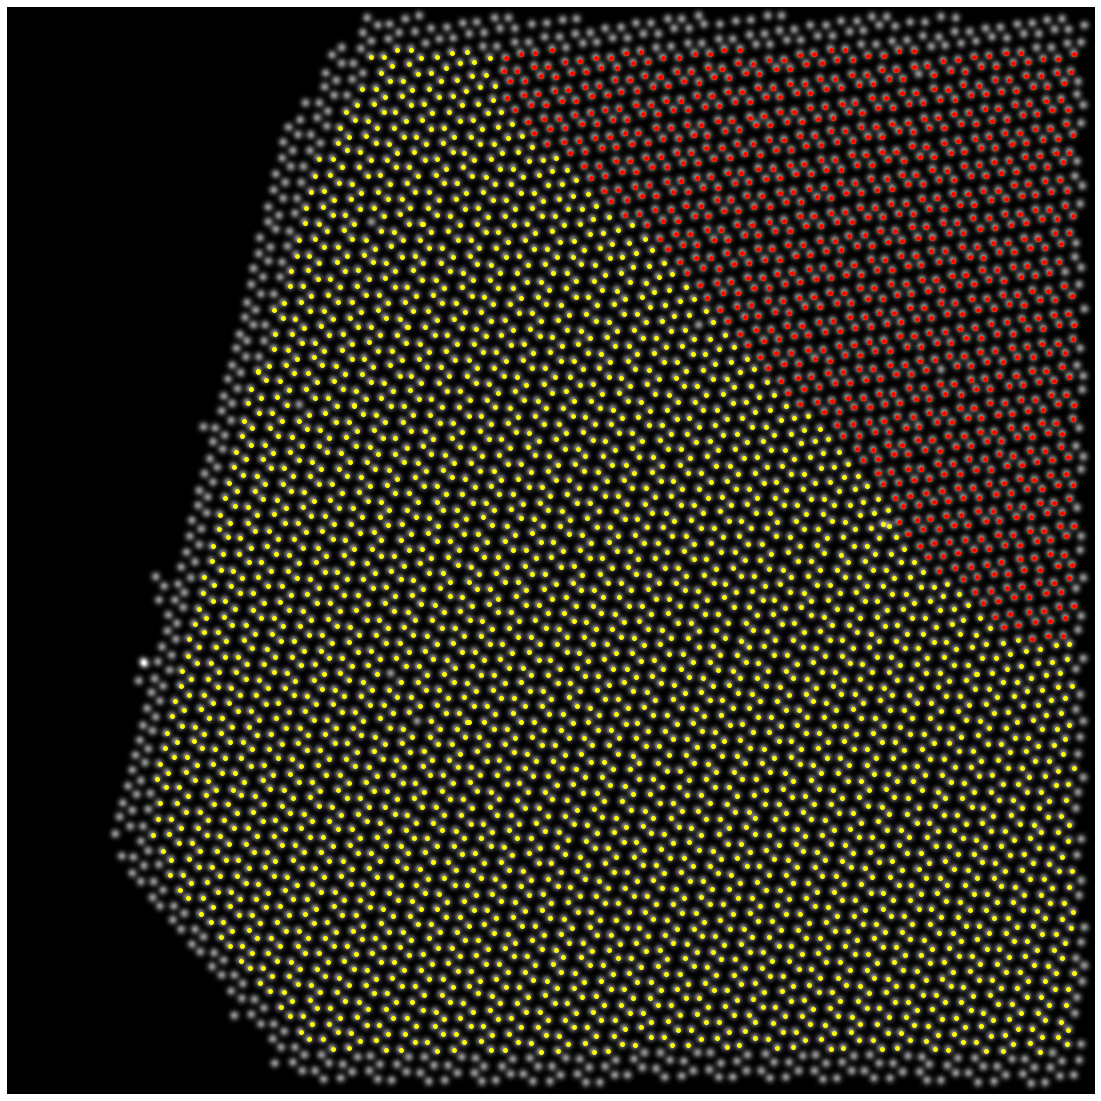

In [ ]:
outlier_coord=atomXY[np.where(color_outlier==-1)]
plt.set_cmap('gray')
plt.figure(figsize=(20,20))
plt.imshow(semantic_image2)
# plt.imshow(IFFT_2)
plt.scatter(atomXY[:,1],atomXY[:,0],s=15,c='yellow')
plt.scatter(outlier_coord[:,1],outlier_coord[:,0],s=15,c='red')
# plt.scatter(atomXY[:,1],atomXY[:,0],s=15,c='r')
plt.axis('off')